# Requirements

In [ ]:
# Add as many imports as you need.

In [1]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from keras.src.models import Sequential
from keras.src.layers import Dense, Input, Dropout, LSTM
import seaborn as sns 
import numpy as np

# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the primary objective is to use Long Short-Term Memory (LSTM) networks for time series forecasting in order to predict the current **mean temperature** in the city of Delhi. To accomplish this use data from the past three days, which includes information such as the **mean temperature**, **humidity**, **wind speed**, and **mean pressure**. The goal is to employ LSTM, a type of recurrent neural network, to effectively forecast the future mean temperature based on the provided historical data.

**Note: You are required to perform this laboratory assignment on your local machine.**

## The Climate Dataset

## Downloading the Climate Dataset

## Exploring the Climate Dataset
This dataset consists of daily weather records for the city of Delhi spanning a period of 4 years (from 2013 to 2017). The dataset includes the following attributes:

- date - date in the format YYYY-MM-DD,
- meantemp - mean temperature averaged from multiple 3-hour intervals in a day,
- humidity - humidity value for the day (measured in grams of water vapor per cubic meter volume of air),
- wind_speed - wind speed measured in kilometers per hour, and
- meanpressure - pressure reading of the weather (measured in atm).

*Note: The dataset is complete, with no missing values in any of its entries.*

Load the dataset into a `pandas` data frame.

In [ ]:
# Write your code here. Add as many boxes as you need.

In [2]:
data = pd.read_csv("./data/climate-data.csv")

Explore the dataset using visualizations of your choice.

In [ ]:
# Write your code here. Add as many boxes as you need.

In [115]:
data

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [3]:
data.set_index("date", inplace=True)

In [117]:
data.isnull().sum() / len(data) * 100

meantemp        0.0
humidity        0.0
wind_speed      0.0
meanpressure    0.0
dtype: float64

## Feauture Extraction
Apply a lag of one, two, and three days to each feature, creating a set of features representing the meteorological conditions from the previous three days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

*Be careful when extracting the features. For each day, ensure that features are obtained sequentially, starting with those from 3 days ago, followed by features from 2 days ago, and finally, features from 1 day ago. This becomes crucial when reshaping the train and test sets later on.*

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [ ]:
# Write your code here. Add as many boxes as you need.

In [4]:
columns = data.columns
lags = 3
for i in range(1, lags + 1):
    for col in columns:
        data[f'{col}_prev_{i}'] = data[col].shift(i)

In [5]:
data = data.dropna(axis=0)
data

,meantemp,humidity,wind_speed,meanpressure,meantemp_prev_1,humidity_prev_1,wind_speed_prev_1,meanpressure_prev_1,meantemp_prev_2,humidity_prev_2,wind_speed_prev_2,meanpressure_prev_2,meantemp_prev_3,humidity_prev_3,wind_speed_prev_3,meanpressure_prev_3
date,,,,,,,,,,,,,,,,
2013-01-04,8.666667,71.333333,1.233333,1017.166667,7.166667,87.000000,4.633333,1018.666667,7.400000,92.000000,2.980000,1017.800000,10.000000,84.500000,0.000000,1015.666667
2013-01-05,6.000000,86.833333,3.700000,1016.500000,8.666667,71.333333,1.233333,1017.166667,7.166667,87.000000,4.633333,1018.666667,7.400000,92.000000,2.980000,1017.800000
2013-01-06,7.000000,82.800000,1.480000,1018.000000,6.000000,86.833333,3.700000,1016.500000,8.666667,71.333333,1.233333,1017.166667,7.166667,87.000000,4.633333,1018.666667
2013-01-07,7.000000,78.600000,6.300000,1020.000000,7.000000,82.800000,1.480000,1018.000000,6.000000,86.833333,3.700000,1016.500000,8.666667,71.333333,1.233333,1017.166667
2013-01-08,8.857143,63.714286,7.142857,1018.714286,7.000000,78.600000,6.300000,1020.000000,7.000000,82.800000,1.480000,1018.000000,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217,16.850000,67.550000,8.335000,1017.200000,17.142857,74.857143,8.784211,1016.952381,14.000000,94.300000,9.085000,1014.350000
2016-12-29,15.238095,87.857143,6.000000,1016.904762,17.217391,68.043478,3.547826,1015.565217,16.850000,67.550000,8.335000,1017.200000,17.142857,74.857143,8.784211,1016.952381
2016-12-30,14.095238,89.666667,6.266667,1017.904762,15.238095,87.857143,6.000000,1016.904762,17.217391,68.043478,3.547826,1015.565217,16.850000,67.550000,8.335000,1017.200000


## Dataset Splitting
Partition the dataset into training and testing sets with an 90:10 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [ ]:
# Write your code here. Add as many boxes as you need.

In [19]:
# X, Y = data.drop(columns='meantemp'), data['meantemp']
X, Y = data.drop(columns=['meantemp', 'humidity', 'wind_speed', 'meanpressure']), data['meantemp']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42,shuffle=False)

In [7]:
X_train

,meantemp_prev_1,humidity_prev_1,wind_speed_prev_1,meanpressure_prev_1,meantemp_prev_2,humidity_prev_2,wind_speed_prev_2,meanpressure_prev_2,meantemp_prev_3,humidity_prev_3,wind_speed_prev_3,meanpressure_prev_3
date,,,,,,,,,,,,
2013-01-04,7.166667,87.000000,4.633333,1018.666667,7.400000,92.000000,2.980000,1017.800000,10.000000,84.500000,0.000000,1015.666667
2013-01-05,8.666667,71.333333,1.233333,1017.166667,7.166667,87.000000,4.633333,1018.666667,7.400000,92.000000,2.980000,1017.800000
2013-01-06,6.000000,86.833333,3.700000,1016.500000,8.666667,71.333333,1.233333,1017.166667,7.166667,87.000000,4.633333,1018.666667
2013-01-07,7.000000,82.800000,1.480000,1018.000000,6.000000,86.833333,3.700000,1016.500000,8.666667,71.333333,1.233333,1017.166667
2013-01-08,7.000000,78.600000,6.300000,1020.000000,7.000000,82.800000,1.480000,1018.000000,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-03-11,25.562500,57.437500,7.981250,1013.187500,24.000000,57.562500,9.375000,1012.062500,23.428571,60.214286,6.742857,1011.642857
2016-03-12,25.066667,67.800000,6.546667,1012.533333,25.562500,57.437500,7.981250,1013.187500,24.000000,57.562500,9.375000,1012.062500
2016-03-13,24.562500,66.937500,9.487500,1009.562500,25.066667,67.800000,6.546667,1012.533333,25.562500,57.437500,7.981250,1013.187500


## Feauture Scaling
Scale the extracted features using an appropriate scaler.

In [ ]:
# Write your code here. Add as many boxes as you need.

In [20]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Feature Reshaping

Reshape the feature dimensions into the shape `(samples, timesteps, features)`.

In [ ]:
# Write your code here. Add as many boxes as you need.

In [21]:
features_per_time_step = X_train.shape[1] // lags
features_per_time_step

4

In [22]:
X_train.shape

(1167, 12)

In [23]:
(X_train.shape[0], lags, features_per_time_step) # (samples, timesteps, features)

(1167, 3, 4)

In [24]:
X_train = X_train.reshape(X_train.shape[0], lags, features_per_time_step)
X_test = X_test.reshape(X_test.shape[0], lags, features_per_time_step)

In [127]:
Y_train.shape

(1167,)

## Long Short-Term Memory (LSTM) Network
Build a Long Short-Term Memory (LSTM) Network for forecasting the current **mean temperature** based on the extracted features from the previous three days.

Define the forecasting model using the **Keras Sequential API** (`keras.models.Sequential`), incorporating one or more LSTM layers along with additional relevant layers (`keras.layers`). Be cautious when specifying the configuration of the final layer to ensure proper model output for the forecasting task.

In [ ]:
# Write your code here. Add as many boxes as you need.

In [25]:
model = Sequential([
    Input(shape=(3, 4)), # (timesteps, features)
    LSTM(64, activation="relu", return_sequences=True),
    LSTM(32, activation="relu"),   
    Dense(1, activation="linear")
])

Compile the previously defined model specifying **loss function** (`keras.losses`), **optimizer** (`keras.optimizers`) and **evaluation metrics** (`keras.metics`).

In [66]:
# Write your code here. Add as many boxes as you need.

In [42]:
model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=["mean_squared_error"]
)

In [47]:
history = model.fit(
    X_train,
    Y_train,
    epochs=40,
    batch_size=16,
    validation_split=0.2,
    shuffle=False 
)

Epoch 1/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1580 - mean_squared_error: 5.1580 - val_loss: 1.6650 - val_mean_squared_error: 1.6650
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5885 - mean_squared_error: 3.5885 - val_loss: 3.4090 - val_mean_squared_error: 3.4090
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3389 - mean_squared_error: 4.3389 - val_loss: 1.7833 - val_mean_squared_error: 1.7833
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1546 - mean_squared_error: 3.1546 - val_loss: 2.8301 - val_mean_squared_error: 2.8301
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6207 - mean_squared_error: 3.6207 - val_loss: 2.0384 - val_mean_squared_error: 2.0384
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1031 - mean_squared_error: 3.1031 - val_loss: 2.7242 - val_mean_squared_error: 2.7242
Epoch 7/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4183 - mean_squared_error: 3.4183 - val_loss: 2.1420 - val_mean_

Train the model on the training set, specifying the **batch size** and **number of epochs** for the training process. Allocate 20% of the samples for **validation**, and ensure that the dataset remains **unshuffled** during training.

In [ ]:
# Write your code here. Add as many boxes as you need.

Create a line plot illustrating both the **training** and **validation loss** over the training epochs.

In [ ]:
# Write your code here. Add as many boxes as you need.

<Axes: >

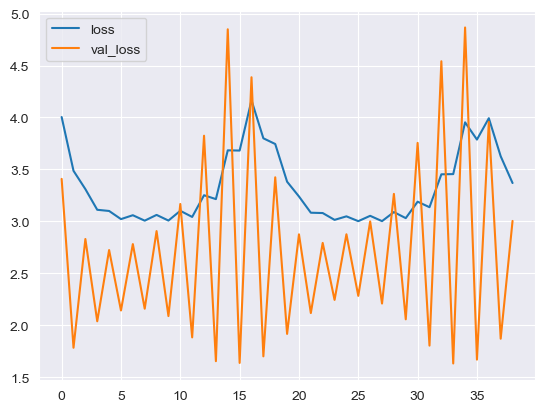

In [48]:
sns.lineplot(history.history['loss'][1:], label='loss')
sns.lineplot(history.history['val_loss'][1:], label='val_loss')

Use the trained model to make predictions for the test set.

In [39]:
# Write your code here. Add as many boxes as you need.

In [49]:
Y_pred = model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [ ]:
# Write your code here. Add as many boxes as you need.

In [50]:
r2_score(Y_test, Y_pred)

-9.177540121904498

Create a line plot in order to compare the actual and predicted mean temperatures for the test set.

In [ ]:
# Write your code here. Add as many boxes as you need.

# Laboratory Exercise - Bonus Task (+ 2 points)

As a bonus task for this laboratory exercise, calculate the Simple Moving Average (SMA) and Weighted Moving Average (WMA) with 3 timesteps for `mean_temperature` over the past 1, 2, and 3 days:

- **SMA with 3 timesteps ($\text{SMA}_3$)** - the average of temperatures from the previous 3 days:  
  $SMA_3 = \frac{\text{mean\_temperaure}_{lag\_3} +\ \text{mean\_temperaure}_{lag\_2} +\ \text{mean\_temperaure}_{lag\_1}}{1\ +\ 1\ +\ 1}$.

- **WMA with 3 timesteps ($\text{WMA}_3$)** - a weighted average, giving more importance to recent days:  
  $WMA_3 = \frac{1\ \cdot\ \text{mean\_temperaure}_{lag\_3} +\ 2\ \cdot\ \text{mean\_temperaure}_{lag\_2} +\ 3\ \cdot\ \text{mean\_temperaure}_{lag_1}}{1\ +\ 2\ +\ 3}$.

Then use this indicators alongside the other features in the dataset to predict the `mean_temperaure`.

*Hint: Use the `rolling` method from `pandas`. Check the docs at the following link https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html.*

In [ ]:
# Write your code here. Add as many boxes as you need.

In [157]:
data2 = data.copy()

In [158]:
data2['SMA_3'] = (
    data2['meantemp_prev_1'] + 
    data2['meantemp_prev_2'] + 
    data2['meantemp_prev_3']
) / 3

In [159]:
data2['SMA_3_WAY2'] = data2['meantemp'].shift(1).rolling(window=3).mean()

In [160]:
weights = [1, 2, 3]
data2['WMA_3'] = (
    1 * data2['meantemp_prev_3'] + 
    2 * data2['meantemp_prev_2'] + 
    3 * data2['meantemp_prev_1']
) / sum(weights)

In [161]:
weights = [1, 2, 3] 
data2['WMA_3_WAY2'] = (
    data2['meantemp']
    .shift(1) 
    .rolling(window=3)
    .apply(lambda x: np.dot(x, weights) / sum(weights), raw=True)
)

In [162]:
data2

,meantemp,humidity,wind_speed,meanpressure,meantemp_prev_1,humidity_prev_1,wind_speed_prev_1,meanpressure_prev_1,meantemp_prev_2,humidity_prev_2,wind_speed_prev_2,meanpressure_prev_2,meantemp_prev_3,humidity_prev_3,wind_speed_prev_3,meanpressure_prev_3,SMA_3,SMA_3_WAY2,WMA_3,WMA_3_WAY2
date,,,,,,,,,,,,,,,,,,,,
2013-01-04,8.666667,71.333333,1.233333,1017.166667,7.166667,87.000000,4.633333,1018.666667,7.400000,92.000000,2.980000,1017.800000,10.000000,84.500000,0.000000,1015.666667,8.188889,NaN,7.716667,NaN
2013-01-05,6.000000,86.833333,3.700000,1016.500000,8.666667,71.333333,1.233333,1017.166667,7.166667,87.000000,4.633333,1018.666667,7.400000,92.000000,2.980000,1017.800000,7.744444,NaN,7.955556,NaN
2013-01-06,7.000000,82.800000,1.480000,1018.000000,6.000000,86.833333,3.700000,1016.500000,8.666667,71.333333,1.233333,1017.166667,7.166667,87.000000,4.633333,1018.666667,7.277778,NaN,7.083333,NaN
2013-01-07,7.000000,78.600000,6.300000,1020.000000,7.000000,82.800000,1.480000,1018.000000,6.000000,86.833333,3.700000,1016.500000,8.666667,71.333333,1.233333,1017.166667,7.222222,7.222222,6.944444,6.944444
2013-01-08,8.857143,63.714286,7.142857,1018.714286,7.000000,78.600000,6.300000,1020.000000,7.000000,82.800000,1.480000,1018.000000,6.000000,86.833333,3.700000,1016.500000,6.666667,6.666667,6.833333,6.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217,16.850000,67.550000,8.335000,1017.200000,17.142857,74.857143,8.784211,1016.952381,14.000000,94.300000,9.085000,1014.350000,15.997619,15.997619,16.472619,16.472619
2016-12-29,15.238095,87.857143,6.000000,1016.904762,17.217391,68.043478,3.547826,1015.565217,16.850000,67.550000,8.335000,1017.200000,17.142857,74.857143,8.784211,1016.952381,17.070083,17.070083,17.082505,17.082505
2016-12-30,14.095238,89.666667,6.266667,1017.904762,15.238095,87.857143,6.000000,1016.904762,17.217391,68.043478,3.547826,1015.565217,16.850000,67.550000,8.335000,1017.200000,16.435162,16.435162,16.166511,16.166511
